## Capstone Project - The Battle of the Neighbourhoods - A Frankfurt Analysis

### Applied Data Science Capstone by IBM / Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

For the final project of the IBM Data Science Professional Certificate, I am proposing an analysis of the neighbourhoods of Frankfurt in order to find the optimal location for a new **Italian Pastry Shop** in **Frankfurt**, Germany.

The challenge will be to find locations relatively free from competitors and with similar characteristics, and among them, to select the one with the "lowest" rental price.

In particular, KMeans will help use to define neighbourhoods with similar characteristics to the **Innenstadt**.

## Data <a name="data"></a>


According to our business problem, there are several factors to be considered in the analysis:


* number of restaurant in the neighbourhood
* number of direct competitors in the area (pastry shops, italian restaurants, etc.)
* number of inhabitants per neighbourhood (related to n° of restaurants)
* average rent prices in the neighbourhood


In order to retrieve the data of the Frankfurt Area (names, density, prices) BeautifulSoup will be exploited to parse html websites.

Following data sources will be needed to generate the required information:

* Neighbourhoods Data : https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main

* Prices per Neighbourhood:
https://www.wohnungsboerse.net/mietspiegel-Frankfurt/3242

* number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API


After having retrieved the data from the websites, latitude and longitude will be extracted through a geolocator object (ArcGIS or Nominatim), and a map will be showed to locate the different neighbourhoods on the map.


Analzying prices, population and presence of competitors, the best trade-off (and therefore best neighbourhood for the new restaurant) will be found

### Importing Libraries

In [86]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import math
import pyproj

import json # library to handle JSON files
import lxml

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import ArcGIS
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium.plugins import MarkerCluster, HeatMap



print('Libraries imported.')

Libraries imported.


### Retrieving Information on Neighbourhoods from HTML Page through BeautifulSoup

In [87]:
# retrieving name and inhabitants data of Frankfurt
url_wiki = "https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main"

page = requests.get(url_wiki)

# BeautifulSoup uses lxml as default parser when installed in the environment
soup = BeautifulSoup(page.content)

In [88]:
# let´s first individuate the table in the page
ff_table = soup.find_all("table", class_="wikitable sortable zebra mw-collapsible")

# save the headers of the table (just in case)
header = [th.text.rstrip() for th in ff_table[0].find_all("th")]

# extract name, inhabitants, and inhabitants per m^2 from the table
c1 = []
c2 = []
c3 = []


for row in ff_table[0].find_all("tr"):
    
    cells = row.find_all("td")
    
    if (cells):
        
        # data of the airport N/A and not of particular interest
        if cells[1].getText().strip() == "Flughafen":
            continue
            
            
        
        else:
            
            c1.append(cells[1].getText().strip())
            c2.append(cells[3].find_all("span")[0].next_sibling.strip())
            c3.append(cells[9].getText().strip())
            
# create a dataframe to store the extracted data, translate from german to english
ff_df = pd.DataFrame(columns=["Neighbourhood", "Inhabitants", "Inhabitants (per km2)"])
ff_df["Neighbourhood"] = c1
ff_df["Inhabitants"] = c2
ff_df["Inhabitants (per km2)"] = c3

# some cleaning and formatting
ff_df.replace(".", "", inplace=True)
ff_df.drop(ff_df.tail(1).index,inplace=True) # drop last 
ff_df["Inhabitants"] = ff_df["Inhabitants"].astype(str).str.replace('\.','').astype(int)
ff_df["Inhabitants (per km2)"] = ff_df["Inhabitants (per km2)"].astype(int)

<ipython-input-88-1037c0f4d3e8>:40: FutureWarning: The default value of regex will change from True to False in a future version.
  ff_df["Inhabitants"] = ff_df["Inhabitants"].astype(str).str.replace('\.','').astype(int)


In [89]:
# showing what we obtained
ff_df.head(10)

,Neighbourhood,Inhabitants,Inhabitants (per km2)
0,Altstadt,4218,8336
1,Innenstadt,6599,4426
2,Bahnhofsviertel,3552,6554
3,Westend-Süd,19314,7735
4,Westend-Nord,10373,6356
5,Nordend-West,30897,9967
6,Nordend-Ost,23182,15132
7,Ostend,29477,5298
8,Bornheim,30917,11097
9,Gutleutviertel,6964,3886


### Retrieving Locations´ Coordinates

In [90]:
# extraction of coordinates of Frankfurt and its neighbourhoods' centers
g=geocoder.arcgis('Frankfurt, Germany')
latitude = round(g.latlng[0], 3)
longitude = round(g.latlng[1], 3)

print("The city of Frankfurt am Main is located at Latitude: {}, Longitude: {}".format(latitude, longitude))

try:
    
    for index, row in ff_df.iterrows():
        neigh = ff_df.loc[index, "Neighbourhood"]
        g=geocoder.arcgis('{}, Frankfurt, Germany'.format(neigh))
        ff_df.at[index, "Latitude"] = g.latlng[0]
        ff_df.at[index, "Longitude"] = g.latlng[1]
except:
    print("Retrieving of coordinates not possible")
    
    
# round coordinates up
ff_df = ff_df.round({"Latitude": 3, "Longitude": 3})
ff_df.head(8)

The city of Frankfurt am Main is located at Latitude: 50.112, Longitude: 8.683


,Neighbourhood,Inhabitants,Inhabitants (per km2),Latitude,Longitude
0,Altstadt,4218,8336,50.111,8.684
1,Innenstadt,6599,4426,50.114,8.671
2,Bahnhofsviertel,3552,6554,50.108,8.670
3,Westend-Süd,19314,7735,50.124,8.669
4,Westend-Nord,10373,6356,50.124,8.669
5,Nordend-West,30897,9967,50.129,8.684
6,Nordend-Ost,23182,15132,50.129,8.684
7,Ostend,29477,5298,50.116,8.698


### Calculating distance of each Neighbourhood from the City Center


The analysis will focus only on areas close to the city center, so let´s calculate the distances in order to perform a first selection later on

In [91]:
# computing distance of each neighbourhood from center
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

frankfurt_center_x, frankfurt_center_y = lonlat_to_xy(longitude, latitude)

distances_from_center = []

for lat, lon in zip(ff_df["Latitude"], ff_df["Longitude"]):
    
    x, y = lonlat_to_xy(lon, lat)
    distance_from_center = calc_xy_distance(frankfurt_center_x, frankfurt_center_y, x, y)
    distances_from_center.append(distance_from_center)

ff_df["Distance from Center"] = distances_from_center

<ipython-input-91-ff64d1314fab>:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-91-ff64d1314fab>:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-91-ff64d1314fab>:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-91-ff64d1314fab>:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-91-ff64d1314fab>:7: DeprecationWarning: This func

In [109]:
ff_df.head(10)

,Neighbourhood,Inhabitants,Inhabitants (per km2),Latitude,Longitude,Distance from Center
0,Altstadt,4218,8336,50.111,8.684,132.523862
1,Innenstadt,6599,4426,50.114,8.671,888.561459
2,Bahnhofsviertel,3552,6554,50.108,8.670,1033.049789
3,Westend-Süd,19314,7735,50.124,8.669,1672.109721
4,Westend-Nord,10373,6356,50.124,8.669,1672.109721
5,Nordend-West,30897,9967,50.129,8.684,1896.265489
6,Nordend-Ost,23182,15132,50.129,8.684,1896.265489
7,Ostend,29477,5298,50.116,8.698,1163.925020
8,Bornheim,30917,11097,50.131,8.711,2917.469831
9,Gutleutviertel,6964,3886,50.103,8.662,1809.062949


### Frankfurt Neighbourhoods

In [93]:
# showing the neighbourhoods on the map
frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, long, neigh in zip(ff_df.Latitude, ff_df.Longitude, ff_df.Neighbourhood):
    
    folium.Marker(
        location = [lat, long],
        icon = None,
        popup = neigh,
    ).add_to(frankfurt_map)

    
frankfurt_map

### Frankfurt Neighbourhoods Clustered

In [94]:
#showing a map with clustered markers
frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=12)

cluster = MarkerCluster().add_to(frankfurt_map)

for lat, long, neigh in zip(ff_df.Latitude, ff_df.Longitude, ff_df.Neighbourhood):
    
    folium.Marker(
        location = [lat, long],
        icon = None,
        popup = neigh,
    ).add_to(cluster)

    
frankfurt_map

### Foursquare API

Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in everything that concerns food & beverage, but only those that are proper restaurants - direct competitors are mainly italian restaurants, pastry shops, café, and ice cream shops.
For each neighbourhood we will consider how many general and direct competitors are currently operating in the area.

In [661]:
# saving data for the Foursquare API
CLIENT_ID = "Z2IVT51NHWFTCLCFGBLAZ4AW3LACJLNYT1WSCXYSRQ0XFG3I"
CLIENT_SECRET ="1XWWPHJFNN3Q141V0AZYW3CUQBEP3CL4KS2P2IVCSRJMNUOI"
VERSION = "20210406"
LIMIT = 100 # A default Foursquare API limit value



print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print("VERSION:" + VERSION)

Your credentails:
CLIENT_ID: Z2IVT51NHWFTCLCFGBLAZ4AW3LACJLNYT1WSCXYSRQ0XFG3I
CLIENT_SECRET:1XWWPHJFNN3Q141V0AZYW3CUQBEP3CL4KS2P2IVCSRJMNUOI
VERSION:20210406


In [96]:
# function to extract the messy category from the response of the API
def extract_category(row):
    try:
        category = row["categories"]
    
    except:
        category = row["venue.categories"]
        
    if len(category) == 0:
        return None
    
    else:
        return category[0]["name"]

In [97]:
# function to get the main venues (top 100) for every neighbourhood in a radius
# of 500 meters from the neighbourhood´s center
def getNearbyVenues(database, radius = 500):
    
    # type your answer here
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    CLIENT_ID = 'Z2IVT51NHWFTCLCFGBLAZ4AW3LACJLNYT1WSCXYSRQ0XFG3I' # Foursquare ID
    CLIENT_SECRET = 'ZSH14QPJXZR3C0YRRK3S0AFV544ZLH4VCF4M1LJRTPR1U1G2' #  Foursquare Secret
    VERSION = '20210304' # Foursquare API version
    RADIUS = 500 # radius of search
    
    venues_list = []
    for neigh, inh, inhs, lat, long, distance in zip(database["Neighbourhood"], database["Inhabitants"], database["Inhabitants (per km2)"], database["Latitude"], database["Longitude"], database["Distance from Center"]):
#         print(neigh)
        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION,
            lat, 
            long, 
            RADIUS, 
            LIMIT)
        
        result = requests.get(url).json()
        
        venues = result["response"]["groups"][0]["items"]
        
        for v in venues:
            
            venues_list.append({"Neighbourhood Name": neigh, 
                              "Neighbourhood Latitude": lat, 
                              "Neighbourhood Longitude": long,
                              "Inhabitants": inh,
                              "Inhabitants (per km2)": inhs,
                              "Distance from Center": distance,  
                              "Venue Name": v["venue"]["name"], 
                              "Venue Latitude": v["venue"]["location"]["lat"], 
                              "Venue Longitude": v["venue"]["location"]["lng"],
                              "Venue Category": v["venue"]["categories"][0]["name"]
                             })
            
        venues_df = pd.DataFrame(venues_list)
            
    return venues_df 


In [477]:
# creating the database
frankfurt_venues = getNearbyVenues(ff_df)

# rounding up
frankfurt_venues = frankfurt_venues.round({"Venue Latitude": 3, "Venue Longitude": 3})

frankfurt_venues.head(10)

,Neighbourhood Name,Neighbourhood Latitude,Neighbourhood Longitude,Inhabitants,Inhabitants (per km2),Distance from Center,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt,50.111,8.684,4218,8336,132.523862,SCHIRN Kunsthalle,50.110,8.684,Art Museum
1,Altstadt,50.111,8.684,4218,8336,132.523862,Kleinmarkthalle,50.113,8.683,Market
2,Altstadt,50.111,8.684,4218,8336,132.523862,Römerberg,50.110,8.682,Plaza
3,Altstadt,50.111,8.684,4218,8336,132.523862,Dom Aussichtsplattform,50.111,8.685,Scenic Lookout
4,Altstadt,50.111,8.684,4218,8336,132.523862,Weinterasse Rollanderhof,50.112,8.682,Wine Bar
5,Altstadt,50.111,8.684,4218,8336,132.523862,Carhartt,50.112,8.682,Boutique
6,Altstadt,50.111,8.684,4218,8336,132.523862,Hoppenworth & Ploch,50.111,8.684,Café
7,Altstadt,50.111,8.684,4218,8336,132.523862,MehlWasserSalz,50.112,8.685,Bakery
8,Altstadt,50.111,8.684,4218,8336,132.523862,Bitter & Zart Chocolaterie,50.111,8.684,Chocolate Shop
9,Altstadt,50.111,8.684,4218,8336,132.523862,The Holy Cross Brewing Society,50.110,8.687,Café


In [568]:
# save the indexes of everything considered as food & beverage
to_watch = frankfurt_venues["Venue Category"].str.contains("Restaurant|Pub|Cream|Pastry|wurst|Pizza|Dessert|Salad|Breakfast|Taverna|Grocery|Sandwich|Fried|Fruit|Café|Coffee")

# save all the venues related to food & beverage in a dataframe
frankfurt_to_watch = frankfurt_venues.loc[to_watch, :].reset_index(drop=True)
frankfurt_to_watch.columns = frankfurt_to_watch.columns.str.replace("Neighbourhood Name", "Neighbourhood")

# individuate direct competitors among the food & beverage venues
competitors_to_watch = frankfurt_to_watch["Venue Category"].str.contains("Italian|Dessert|Ice|Pastry|Trattoria|Sweet|Café|Coffee")
frankfurt_to_watch["is_competitor"] = 0
frankfurt_to_watch.loc[pd.Series(competitors_to_watch), "is_competitor"] = 1


frankfurt_to_watch.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Inhabitants,Inhabitants (per km2),Distance from Center,Venue Name,Venue Latitude,Venue Longitude,Venue Category,is_competitor
0,Altstadt,50.111,8.684,4218,8336,132.523862,Hoppenworth & Ploch,50.111,8.684,Café,1
1,Altstadt,50.111,8.684,4218,8336,132.523862,The Holy Cross Brewing Society,50.110,8.687,Café,1
2,Altstadt,50.111,8.684,4218,8336,132.523862,Metropol Cafe am Dom,50.110,8.686,Café,1
3,Altstadt,50.111,8.684,4218,8336,132.523862,Das Eis,50.113,8.684,Ice Cream Shop,1
4,Altstadt,50.111,8.684,4218,8336,132.523862,Fisch Franke,50.112,8.684,Seafood Restaurant,0


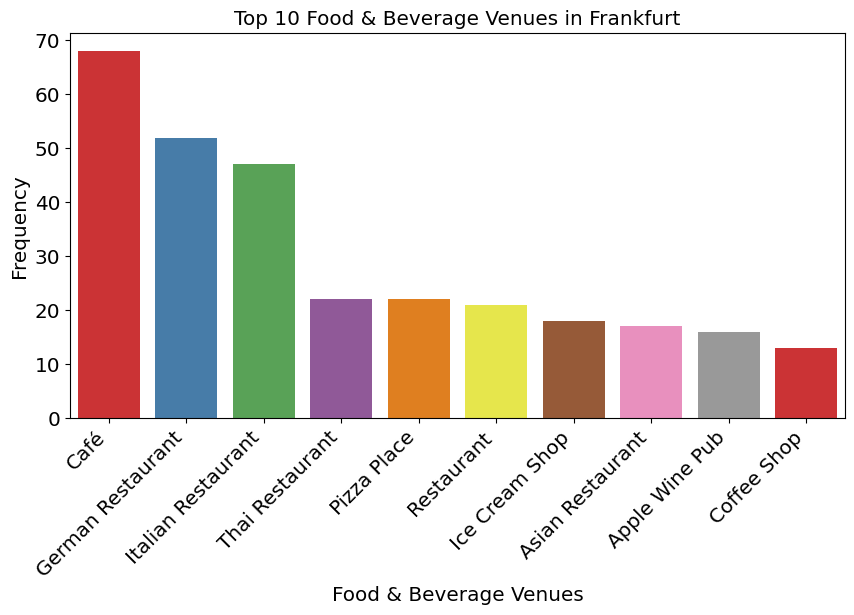

In [711]:
frankfurt_to_watch["Venue Category"]=frankfurt_to_watch["Venue Category"].astype('category')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=frankfurt_to_watch,
    x='Venue Category',
    palette='Set1',
    order = frankfurt_to_watch['Venue Category'].value_counts().head(10).index
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.yticks(
     
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title("Top 10 Food & Beverage Venues in Frankfurt", fontsize="x-large")
plt.xlabel('Food & Beverage Venues', fontsize="x-large")
plt.ylabel('Frequency', fontsize="x-large")

None #don't show the label objects



In [569]:
# showing all the food & beverage venues
frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=12)

cluster = MarkerCluster().add_to(frankfurt_map)

for lat, long, name, pappa in zip(frankfurt_to_watch["Venue Latitude"], frankfurt_to_watch["Venue Longitude"],frankfurt_to_watch["Venue Name"], frankfurt_to_watch["Venue Category"]):
    
    folium.Marker(
        location = [lat, long],
        icon = None,
        popup = pappa,
    ).add_to(cluster)

    
frankfurt_map

In [570]:
# showing competitors related to the total f&b venues
frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, name, pappa, is_comp in zip(frankfurt_to_watch["Venue Latitude"], frankfurt_to_watch["Venue Longitude"],frankfurt_to_watch["Venue Name"], frankfurt_to_watch["Venue Category"], frankfurt_to_watch["is_competitor"]):
    
    color = 'red' if (is_comp == 1) else 'blue'
    folium.CircleMarker([lat, long], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(frankfurt_map)

frankfurt_map

Let´s now analyze each neighbourhood to find out what are the most common venues in the area (comprising the non food & beverage ones), in order to find generic similarities among neighbourhoods

In [571]:
# encoding the venues and saving in a new dataframe
frankfurt_one_hot = pd.get_dummies(frankfurt_venues["Venue Category"])
frankfurt_one_hot.insert(0, "Neighbourhood", frankfurt_venues["Neighbourhood Name"])

frankfurt_one_hot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Apple Wine Pub,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Breakfast Spot,Building,Burger Joint,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Castle,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health Food Store,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lawyer,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Malga,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Nightclub,Opera House,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Restaurant,River,Rock Club,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Soccer Field,Soup Place,Spanish Restaurant,Speakeasy,Sports Bar,Stables,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Taverna,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Zoo
0,Altstadt,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [572]:
# grouping by neighbourhood in a new dataframe, then ordering by frequency and extracting type of venue
frankfurt_grouped = frankfurt_one_hot.groupby("Neighbourhood").mean().reset_index()

columns = ["Neighbourhood"]

n_top_venues = 5

suffix = ["st", "nd", "rd"]


for n in range(1, n_top_venues+1):
    
    try:
        columns.append("{}{} Most Common Venue".format(n, suffix[n-1]))
        
    except:
        columns.append("{}th Most Common Venue".format(n))


frankfurt_sorted = pd.DataFrame(columns=columns)

frankfurt_sorted["Neighbourhood"] = frankfurt_grouped["Neighbourhood"]

for ind in range(0, len(frankfurt_grouped["Neighbourhood"])):
    frankfurt_sorted.iloc[ind, 1:] = frankfurt_grouped.iloc[ind, 1:].sort_values(ascending=False).index.values[0:n_top_venues]

# we obtain a database with the top 5 venues per neighbourhood and respective distances from the center
frankfurt_sorted["Distance from Center"] = ff_df.sort_values("Neighbourhood")["Distance from Center"].reset_index(drop=True)
frankfurt_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Distance from Center
0,Altstadt,Café,Plaza,Restaurant,Clothing Store,Coffee Shop,132.523862
1,Bahnhofsviertel,Hotel,Indian Restaurant,Bar,Restaurant,Café,1033.049789
2,Bergen-Enkheim,Italian Restaurant,Supermarket,German Restaurant,Taverna,African Restaurant,6989.093708
3,Berkersheim,Supermarket,German Restaurant,Shipping Store,Farm,Light Rail Station,6883.736193
4,Bockenheim,Café,Italian Restaurant,Japanese Restaurant,Pizza Place,Supermarket,2662.389596
5,Bonames,Italian Restaurant,Doner Restaurant,German Restaurant,Ice Cream Shop,Metro Station,8018.443225
6,Bornheim,Café,Cocktail Bar,Spanish Restaurant,Italian Restaurant,Gymnastics Gym,2917.469831
7,Dornbusch,Dessert Shop,Supermarket,Metro Station,Thai Restaurant,African Restaurant,3959.464070
8,Eckenheim,Drugstore,German Restaurant,Playground,Supermarket,Bus Stop,4013.397571
9,Eschersheim,German Restaurant,Metro Station,Insurance Office,Tennis Court,Pool,5739.653448


In [573]:
# individuate clusters in the city

k = 9

cluster_df = frankfurt_grouped.drop("Neighbourhood", 1)
clz = KMeans(n_clusters = k, random_state = 0).fit(cluster_df)

clz.labels_[0:10]

array([0, 0, 4, 4, 0, 0, 0, 3, 0, 3])

In [574]:
# inserting clusters in the database and cleaning
frankfurt_sorted.insert(0, "Cluster", clz.labels_)

frankfurt_merged = ff_df
frankfurt_merged = frankfurt_merged.join(frankfurt_sorted.set_index("Neighbourhood").drop("Distance from Center", axis=1), on="Neighbourhood")
frankfurt_merged = frankfurt_merged.reset_index(drop=True)

In [575]:
# adding number of competitors and food & beverage venues for each neighbourhood
competitor_amount = frankfurt_to_watch.sort_values("Neighbourhood").groupby("Neighbourhood").sum()["is_competitor"].to_frame()
restaurants_amount = frankfurt_to_watch.sort_values("Neighbourhood").groupby("Neighbourhood").count()["Venue Category"].to_frame()
amount_analysis = competitor_amount.merge(restaurants_amount, on = "Neighbourhood")
amount_analysis.columns = ["n_competitors", "n_restaurants"]

# adding total competitors and f&b venues in the area
frankfurt_merged = frankfurt_merged.merge(amount_analysis, on="Neighbourhood", how="left").reset_index(drop=True)
frankfurt_merged.replace(np.nan, 0, inplace=True)

# adding n° of inhabitants per competitor and per f&b venue
frankfurt_merged["Inhabitants per competitor"] = frankfurt_merged["Inhabitants"] / frankfurt_merged["n_competitors"]
frankfurt_merged["Inhabitants per restaurant"] = frankfurt_merged["Inhabitants"] / frankfurt_merged["n_restaurants"]

# formatting numbers
frankfurt_merged["Inhabitants per competitor"] = frankfurt_merged["Inhabitants per competitor"].apply(lambda x: '%.2f' % x)
frankfurt_merged["Inhabitants per restaurant"] = frankfurt_merged["Inhabitants per restaurant"].apply(lambda x: '%.2f' % x)

# adding average price per sqm per neighbourhood
prices = [16.83, 28.99, 13.79, 11.69, 22.67, 26.20, 26.31, 15.82, 15.10, 14.22, 25.46, 12.39, 20.40, 14.10, 14.48, 20.28, 12.37, 17.08, 16.08, 16.09, 26.35,17.70, 14.70, 11.92, 12.62, 21.97, 13.56, 25.39, 19.33, 20.84, 24.09, 14.04, 14.48, 16.32, 24.86, 24.28, 24.28, 14.77, 14.77, 13.91, 11.70, 12.49, 17.75, 24.04, 13.48]
frankfurt_merged = frankfurt_merged.sort_values("Neighbourhood").reset_index(drop=True)
frankfurt_merged["Prices per sqm"] = prices

### Showing Neighbourhoods Clustered

We can immediatly notice how central areas share points in common from a point of view of venues in the area. It is interesting to notice that also places in the suburbs like Sindlingen have similarities with the city centre

In [576]:
# Matplotlib and associated plotting modules
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)



# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(frankfurt_merged['Latitude'], frankfurt_merged['Longitude'], frankfurt_merged['Neighbourhood'], frankfurt_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

## Methodology <a name="methodology"></a>


The aim of this project is to detect areas of Frankfurt that haw low competitors density, relatively close to the city centre, and possibly with low rent prices.

In the first step we collected all the geographical data related to Frankfurt and its neighbourhoods through a **geolocator**.

After that, all the relevant venues for the analysis (such as competitors and food & beverage (f&b) venues for each area have been retrieved thanks to the Foursquare API.

Furthermore, we exploited **Clustering** Technique to find similarities among the neighbourhoods, in particular to find out which ones are more similar to the city center.

Now it's time to focus our research in the areas close to the center (< 3.5 km from the center) and highlight the interesting points with an **heatmap**.

In [577]:
# dropping locations more than 6km away from city center
# indexes_drop = frankfurt_merged[(frankfurt_merged.loc[:, "Distance from Center"] >= 5000)].index.values
# frankfurt_merged.drop(indexes_drop, inplace=True)
# frankfurt_merged.reset_index(drop=True)

,Neighbourhood,Inhabitants,Inhabitants (per km2),Latitude,Longitude,Distance from Center,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,n_competitors,n_restaurants,Inhabitants per competitor,Inhabitants per restaurant,Prices per sqm
0,Altstadt,4218,8336,50.111,8.684,132.523862,0,Café,Plaza,Restaurant,Clothing Store,Coffee Shop,16.0,31.0,263.62,136.06,16.83
1,Bahnhofsviertel,3552,6554,50.108,8.670,1033.049789,0,Hotel,Indian Restaurant,Bar,Restaurant,Café,8.0,56.0,444.00,63.43,28.99
2,Bockenheim,41904,5218,50.120,8.648,2662.389596,0,Café,Italian Restaurant,Japanese Restaurant,Pizza Place,Supermarket,15.0,43.0,2793.60,974.51,22.67
3,Bornheim,30917,11097,50.131,8.711,2917.469831,0,Café,Cocktail Bar,Spanish Restaurant,Italian Restaurant,Gymnastics Gym,7.0,20.0,4416.71,1545.85,26.31
4,Dornbusch,18770,7873,50.146,8.667,3959.464070,3,Dessert Shop,Supermarket,Metro Station,Thai Restaurant,African Restaurant,1.0,2.0,18770.00,9385.00,15.82
5,Eckenheim,14392,6385,50.148,8.682,4013.397571,0,Drugstore,German Restaurant,Playground,Supermarket,Bus Stop,0.0,3.0,inf,4797.33,15.10
6,Gallus,41851,9265,50.106,8.641,3084.170267,0,German Restaurant,Asian Restaurant,Bakery,Hotel,Park,2.0,13.0,20925.50,3219.31,20.40
7,Ginnheim,16664,6183,50.145,8.649,4412.055839,4,Supermarket,German Restaurant,Asian Restaurant,Bakery,Trattoria/Osteria,1.0,4.0,16664.00,4166.00,14.10
8,Gutleutviertel,6964,3886,50.103,8.662,1809.062949,0,Hotel,Restaurant,Coffee Shop,Bistro,Italian Restaurant,5.0,23.0,1392.80,302.78,20.28
9,Hausen,7516,6032,50.132,8.623,4843.537632,3,Bus Stop,Metro Station,German Restaurant,Liquor Store,Dance Studio,0.0,5.0,inf,1503.20,17.08


In [578]:
# restricting even more the area, considering only cluster 0 (center) within 3.5 km from city center
indexes_drop = frankfurt_merged[(frankfurt_merged.loc[:, "Cluster"] != 0) | (frankfurt_merged.loc[:, "Distance from Center"] >= 3550)].index.values
frankfurt_merged.drop(indexes_drop, inplace=True)
frankfurt_merged.reset_index(drop=True)

,Neighbourhood,Inhabitants,Inhabitants (per km2),Latitude,Longitude,Distance from Center,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,n_competitors,n_restaurants,Inhabitants per competitor,Inhabitants per restaurant,Prices per sqm
0,Altstadt,4218,8336,50.111,8.684,132.523862,0,Café,Plaza,Restaurant,Clothing Store,Coffee Shop,16.0,31.0,263.62,136.06,16.83
1,Bahnhofsviertel,3552,6554,50.108,8.670,1033.049789,0,Hotel,Indian Restaurant,Bar,Restaurant,Café,8.0,56.0,444.00,63.43,28.99
2,Bockenheim,41904,5218,50.120,8.648,2662.389596,0,Café,Italian Restaurant,Japanese Restaurant,Pizza Place,Supermarket,15.0,43.0,2793.60,974.51,22.67
3,Bornheim,30917,11097,50.131,8.711,2917.469831,0,Café,Cocktail Bar,Spanish Restaurant,Italian Restaurant,Gymnastics Gym,7.0,20.0,4416.71,1545.85,26.31
4,Gallus,41851,9265,50.106,8.641,3084.170267,0,German Restaurant,Asian Restaurant,Bakery,Hotel,Park,2.0,13.0,20925.50,3219.31,20.40
5,Gutleutviertel,6964,3886,50.103,8.662,1809.062949,0,Hotel,Restaurant,Coffee Shop,Bistro,Italian Restaurant,5.0,23.0,1392.80,302.78,20.28
6,Innenstadt,6599,4426,50.114,8.671,888.561459,0,Plaza,Japanese Restaurant,Park,Gym / Fitness Center,German Restaurant,6.0,14.0,1099.83,471.36,26.35
7,Nordend-Ost,23182,15132,50.129,8.684,1896.265489,0,Café,Italian Restaurant,Asian Restaurant,Greek Restaurant,Health Food Store,10.0,20.0,2318.20,1159.10,25.39
8,Nordend-West,30897,9967,50.129,8.684,1896.265489,0,Café,Italian Restaurant,Asian Restaurant,Greek Restaurant,Health Food Store,10.0,20.0,3089.70,1544.85,19.33
9,Oberrad,13594,5020,50.100,8.727,3426.122890,0,German Restaurant,Liquor Store,Plaza,Ice Cream Shop,Tram Station,1.0,4.0,13594.00,3398.50,20.84


In [579]:
!wget -- quiet https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson
print("GeoJSON file downloaded") 

GeoJSON file downloaded


--2021-04-08 13:52:13--  http://quiet/
Resolving quiet (quiet)... failed: Host sconosciuto. .
wget: unable to resolve host address 'quiet'
--2021-04-08 13:52:15--  https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson
Resolving offenedaten.frankfurt.de (offenedaten.frankfurt.de)... 188.40.122.90
Connecting to offenedaten.frankfurt.de (offenedaten.frankfurt.de)|188.40.122.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294241 (287K) [application/geo+json]
Saving to: 'ffmstadtteilewahlen.geojson.3'

     0K .......... .......... .......... .......... .......... 17% 2,06M 0s
    50K .......... .......... .......... .......... .......... 34% 2,75M 0s
   100K .......... .......... .......... .......... .......... 52% 4,28M 0s
   150K .......... .......... .......... .......... .......... 69% 4,03M 0s
   200K .......... .......... .......... .......... .....

In [590]:
# map f&b

frankfurt_geo = r'ffmstadtteilewahlen.geojson'

frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=11)

url = "https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson"
neighs = requests.get(url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

# set color scheme for the clusters
colors_array = ["blue", "red", "yellow"]

markers_colors = []
for lat, lon, poi, cluster in zip(frankfurt_merged['Latitude'], frankfurt_merged['Longitude'], frankfurt_merged['Neighbourhood'], frankfurt_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_array[cluster],
        fill=True,
        fill_color=colors_array[cluster],
        fill_opacity=0.7).add_to(frankfurt_map)
folium.GeoJson(neighs, style_function=boroughs_style, name='geojson').add_to(frankfurt_map)
folium.Marker([latitude, longitude], popup = "City Center").add_to(frankfurt_map)

res_latlons = [[lat, lon] for lat, lon in zip(frankfurt_to_watch["Venue Latitude"], frankfurt_to_watch["Venue Longitude"])]
HeatMap(res_latlons).add_to(frankfurt_map)

frankfurt_map

In [591]:
# map competitors

frankfurt_geo = r'ffmstadtteilewahlen.geojson'

frankfurt_map = folium.Map(location=[latitude, longitude], zoom_start=11)

from folium.plugins import HeatMap
url = "https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson"
neighs = requests.get(url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

# set color scheme for the clusters
colors_array = ["blue", "red", "yellow"]

markers_colors = []
for lat, lon, poi, cluster in zip(frankfurt_merged['Latitude'], frankfurt_merged['Longitude'], frankfurt_merged['Neighbourhood'], frankfurt_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_array[cluster],
        fill=True,
        fill_color=colors_array[cluster],
        fill_opacity=0.7).add_to(frankfurt_map)
folium.GeoJson(neighs, style_function=boroughs_style, name='geojson').add_to(frankfurt_map)
folium.Marker([latitude, longitude], popup = "City Center").add_to(frankfurt_map)
res_latlons = [[lat, lon] for lat, lon, is_comp in zip(frankfurt_to_watch["Venue Latitude"], frankfurt_to_watch["Venue Longitude"], frankfurt_to_watch["is_competitor"]) if is_comp==1]
HeatMap(res_latlons).add_to(frankfurt_map)

frankfurt_map

The Neighbourhoods of **Gallus**, **Gutleutviertel** and **Ostend** seem the most promising from the point of view of competition, let´s now analyze the overall number of inhabitants and the prices for the areas

In [662]:
columns = frankfurt_merged.columns[0:5].append(frankfurt_merged.columns[12:])

best_candidates_df = frankfurt_merged[frankfurt_merged["Neighbourhood"].str.contains("Gallus|Gutleutviertel|Ostend|Osterrand|Westend-Süd")][columns].sort_values("Prices per sqm").reset_index(drop=True)
best_candidates_df

,Neighbourhood,Inhabitants,Inhabitants (per km2),Latitude,Longitude,n_competitors,n_restaurants,Inhabitants per competitor,Inhabitants per restaurant,Prices per sqm
0,Gutleutviertel,6964,3886,50.103,8.662,5.0,23.0,1392.80,302.78,20.28
1,Gallus,41851,9265,50.106,8.641,2.0,13.0,20925.50,3219.31,20.40
2,Westend-Süd,19314,7735,50.124,8.669,9.0,24.0,2146.00,804.75,24.04
3,Ostend,29477,5298,50.116,8.698,8.0,29.0,3684.62,1016.45,24.09


<AxesSubplot:xlabel='Neighbourhood', ylabel='Inhabitants per competitor'>

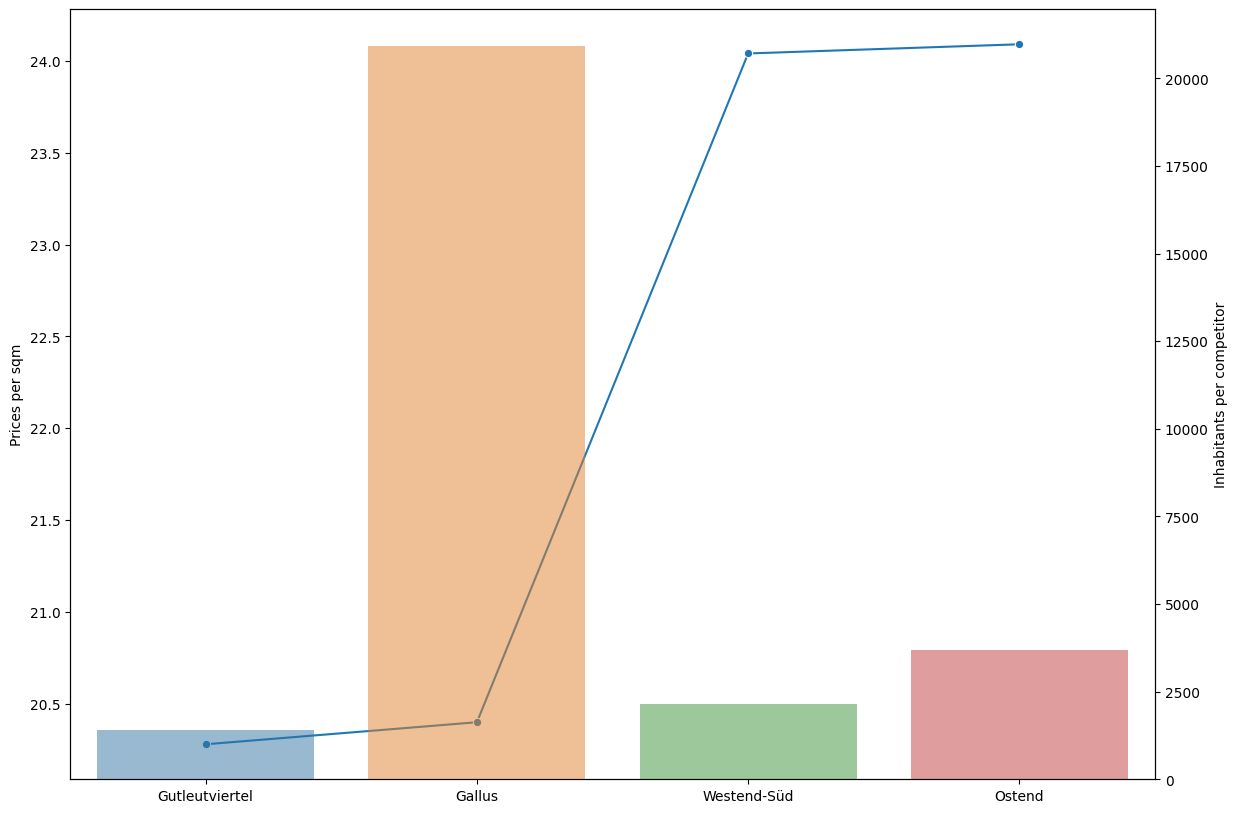

In [663]:
import matplotlib
import seaborn as sns

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

best_candidates_df["Inhabitants per competitor"] = best_candidates_df["Inhabitants per competitor"].astype(float)

fig, ax1 = plt.subplots(figsize=(14,10))

sns.lineplot(data = best_candidates_df["Prices per sqm"], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = best_candidates_df, x='Neighbourhood', y='Inhabitants per competitor', alpha=0.5, ax=ax2)